In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.stats as stats

User functions from the functions_for_analysis.py file:
- plot_ec_silhouette - functuin for visualization of Elbow curve and Silhouette score
- intersections - function to estimate intersection rate between outliers detected by different algorithms
- clusters - function to visualize the manin characteristics of clusters of detected outliers

In [5]:
import functions_for_analysis as ffa

The random state seed may impact on results of algorithms based on k-means clustering.

In [6]:
random_state = 100

# Data preprocess

Read excel file with dataset

In [7]:
data = pd.read_excel('Data_students.xlsx')

The dataset presents information about students' performance during their 1st semester study. It contains 8 features:
- **Student_ID** - student's ID
- **Faculty** - Faculty of student
- **Etmath** -  Enrollment mathematics test
- **Etph** - Enrollment physics test
- **Etch** - Enrollment chemistry test
- **AT1** - Higher mathematics attestation test 1
- **AT2** - Higher mathematics attestation test 2
- **Exam** - Higher mathematics examination test

In [8]:
data.head()

,Student_ID,Faculty,Etmath,Etph,Etch,AT1,AT2,Exam
0,1,Computer Science,4.75,13.00,13.00,12.50,4.090000,4.25
1,2,Computer Science,4.25,6.00,2.50,10.56,3.323333,4.25
2,3,Computer Science,4.00,3.67,10.00,10.69,2.590000,3.40
3,4,Computer Science,4.00,10.00,16.00,7.22,3.840000,3.25
4,5,Computer Science,3.75,3.83,9.58,8.38,2.046667,2.80


Explore numerical features.

Dataset contains tests results for 1075 students. The minimal score which corresponds to the worst result is 0.0 for each test, while maximal score varies.

In [11]:
features_name = ['Etmath','Etph','Etch','AT1','AT2','Exam']
df = data[features_name]
df.describe()

,Etmath,Etph,Etch,AT1,AT2,Exam
count,1075.000000,1075.000000,1075.000000,1016.000000,992.000000,1008.000000
mean,2.767907,7.997358,10.571191,7.219931,2.188360,3.084573
std,1.169112,4.498383,5.499710,2.497395,0.936574,1.059251
min,0.000000,0.000000,0.000000,0.740000,0.000000,0.000000
25%,2.000000,4.330000,6.500000,5.450000,1.466667,2.750000
50%,3.000000,7.330000,9.500000,7.080000,2.098333,3.250000
75%,3.750000,11.000000,14.000000,8.875000,2.827500,3.800000
max,5.000000,20.000000,24.000000,14.720000,4.620000,5.000000


According to the descriptive statistics we can say, that some students passed only enrollment tests and didn't take attestation or exam tests. To avoid loss of information we fill missing values as follows:

In [12]:
df = df.fillna(value = 0.)

Check the distribution of features and how similar they are with normal distribution. Pearson’s test shows that all features significantly differ from the normal distribution (p-value<0.0005).

In [13]:
for feature in df.columns:
    var = df[feature]
    k, p = stats.normaltest(var)
    print(f'{str(feature)}. Statistic: {k.round(2)}, P-value:{p.round(5)}')  

Etmath. Statistic: 64.03, P-value:0.0
Etph. Statistic: 62.36, P-value:0.0
Etch. Statistic: 64.39, P-value:0.0
AT1. Statistic: 18.16, P-value:0.00011
AT2. Statistic: 23.64, P-value:1e-05
Exam. Statistic: 109.03, P-value:0.0


We check the relation between features. According to correlation matrix, they are positively correlated. 

Use Spearman correlation coefficient since features significantly differ from normal distribution.

In [14]:
data[features_name].corr('spearman').round(3)

,Etmath,Etph,Etch,AT1,AT2,Exam
Etmath,1.000,0.574,0.445,0.631,0.634,0.532
Etph,0.574,1.000,0.315,0.441,0.478,0.430
Etch,0.445,0.315,1.000,0.399,0.354,0.369
AT1,0.631,0.441,0.399,1.000,0.666,0.641
AT2,0.634,0.478,0.354,0.666,1.000,0.641
Exam,0.532,0.430,0.369,0.641,0.641,1.000


 # Outlier Detection

In [15]:
df_outliers = df.copy()

## Abnormal values

Firstly, detect abnormal values by two algorithms: **3*sigma** and **1,5*IQR** thumb rules.

**1. 1.5*IQR**

In [17]:
var = df

Q1 = var.quantile(0.25)
Q3 = var.quantile(0.75)

IQR = Q3-Q1

lower_limit_iqr = Q1-1.5*IQR
upper_limit_iqr = Q3+1.5*IQR

point_out_inds_iqr = []
for feature in df.columns:
    aa = df[(df[feature]>upper_limit_iqr[feature]) | (df[feature]<lower_limit_iqr[feature])]
    point_out_inds_iqr.append(list(aa.index))

point_outliers_iqr = pd.Series( point_out_inds_iqr).explode().dropna().unique()
print(f'Number of abnormal values detected by 1.5*IQR: {len(point_outliers_iqr)}')

Number of abnormal values detected by 1.5*IQR: 105


**2. 3*sigma**

In [18]:
df_std = df.std()*3
df_mean = df.mean()

lower_limit = df_mean - df_std 
upper_limit = df_mean + df_std 

point_out_inds = []
for feature in df.columns:
    aa = df[(df[feature]>=upper_limit[feature]) | (df[feature]<=lower_limit[feature])]
    point_out_inds.append(list(aa.index))
    
point_outliers = pd.Series(point_out_inds).explode().dropna().unique()
print(f'Number of abnormal values detected by 3*sigma: {len(point_outliers)}')

Number of abnormal values detected by 3*sigma: 0


**Visualization of abnormal values.**

Here, the box corresponds to the IQR, the horizontal line inside the box shows the median, the whiskers denote
the [Q1−1.5∗IQR; Q3+1.5∗IQR] interval, the circle white point shows mean value, and the colored background denotes the [mean − 3 ∗ std; mean + 3 ∗ std] interval. The abnormal values defined as deviations from the mean (less than
mean − 3 ∗ std or more than mean + 3 ∗ std) have not been found. The observations which fell beyond the whiskers have been found for features AT1 and Exam. Where abnormal values for AT1 correspond to the highest scores, while
abnormal values for Exam corresponds the lowest score. This means that the majority of students do not pass the first attestation tests with excellent scores, but they tend to pass the exam.

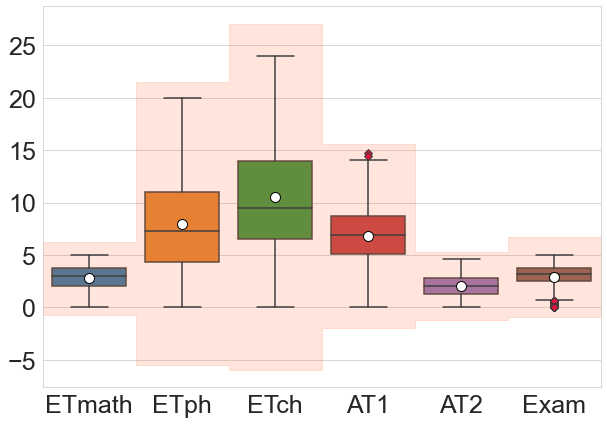

In [19]:
y1=[]
for i in lower_limit:
    y1.extend([i,i])
y2 = []
for i in upper_limit:
    y2.extend([i,i])


plt.figure(figsize = (10,7))
sns.set_style("whitegrid")
x = (-0.5,0.5,0.5,1.5,1.5,2.5,2.5,3.5,3.5,4.5,4.5,5.5)
plt.fill_between(x,y1,y2, alpha =0.2, color = 'coral')

sns.boxplot(x="variable", y="value", data=pd.melt(df),dodge=False,showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
                    flierprops=dict(markerfacecolor="crimson", marker="D"))
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1,2,3,4,5],['ETmath','ETph','ETch', 'AT1', 'AT2', 'Exam'],fontsize = 25)
plt.yticks(fontsize = 25);

## Global and Local outliers

Secondly, detect global outliers - data objects which significantly differ from the majority of observations in the considered dataset in terms of considered set of features, and local outliers - data objects which lay in the areas of sparse density.

Here, we will consider four unsupervised outlier detection algorithms distance-based kNN, cluster-based CBLOF, density-based LOF, and statistic-based HBOS. We will use [PyOD](https://pyod.readthedocs.io/en/latest/index.html) library which contains almost all state-of-the-art outlier detection algorithms.

### kNN

Extract function which detects outliers by [kNN](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn) algorithm from PyOD.

In [20]:
from pyod.models.knn import KNN

Since the considered features are represented in different scales, they have to be standardized.

In [21]:
X = np.array(df)
X = StandardScaler().fit_transform(X)

The algortihm requires several predefined parameters:
- **k** - number of nearest neighbors;
- **contamination** - assumption about the proportion of outliers in the data set;
- **method** - the way of estimatin outlier score;
- **metric** - metric for estimation distance between objects.

In this case we consider k = 50 with contamination 10%, which are mostly used as standard values of parameters for this algorithm ([Goldstein and Uchida](https://doi.org/10.1371/journal.pone.0152173)).

In [22]:
k=50
df_outliers['knn_10'] =  KNN(contamination=0.1, n_neighbors=k, method='mean', algorithm='ball_tree', metric='euclidean').fit(X).labels_

### CBLOF

Extract function which detects outliers by [CBLOF](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof) algorithm from PyOD.

In [23]:
from pyod.models.cblof import CBLOF
import warnings
warnings.filterwarnings('ignore')

Since CBLOF algorithm is based on clustering, it's necessary to identify number of clusters. To find optimal number of clusters, we will use Elbow curve and Silhouette score.

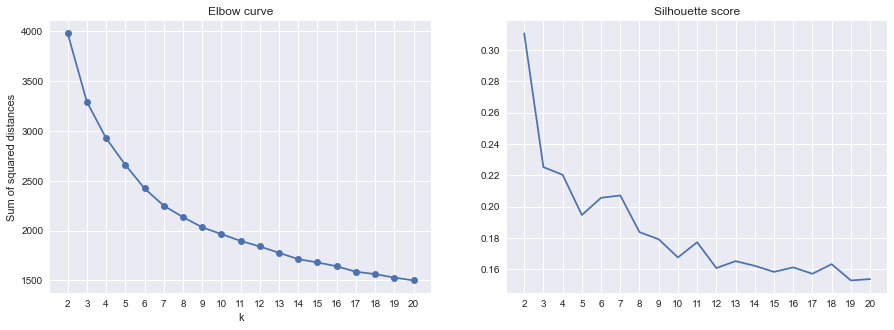

In [24]:
ffa.plot_ec_silhouette(X, random_state)

The algorithm requires the following predefined parameters:

- **k** - number of nearest neighbors;
- **contamination** - assumption about the proportion of outliers in the data set;
- **alpha** - coefficient for deciding small and large clusters. The ratio of the number of samples in large clusters to the number of samples in small clusters;
- **beta** - coefficient for deciding small and large clusters.

In this case we consider k = 6 due to Elbow curve and Silhouete score, the clustering algorithm k-means, the parameters α =
0.8, β = 5, with contamination 10% ([He et al.](https://doi.org/10.1016/S0167-8655(03)00003-5)).

In [25]:
k=6
alpha = 0.8
beta = 5
df_outliers['cblof_10'] = CBLOF(n_clusters=k, contamination=0.1, alpha=alpha, beta=beta,random_state = random_state).fit(X).labels_

### HBOS

Extract function which detects outliers by [HBOS](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.hbos) algorithm from PyOD.

In [26]:
from pyod.models.hbos import HBOS

The algorithm requires the following predefined parameters:

- **n_bins** - the number of bins. 
- **contamination** - assumption about the proportion of outliers in the data set.
 
In this case we consider n_bins = 33, since the rule of thumb determines number of bins by the square root of the number of instances N (1075). 

In [27]:
df_outliers['hbos_10'] = HBOS(n_bins=33, contamination=0.1).fit(X).labels_

## Local outliers

### LOF

Extract function which detects outliers by [LOF](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lof) algorithm from PyOD.

In [28]:
from pyod.models.lof import LOF

The algortihm requires several predefined parameters:

- **k** - number of nearest neighbors;
- **contamination** - assumption about the proportion of outliers in the data set;
- **algorithm** - algorithm used to compute the nearest neighbors;
- **metric** - metric for estimation distance between objects.

In this case we consider k = 50 with contamination 10%, which are mostly used as standard values of parameters for this algorithm ([Breunig et al.](https://doi.org/10.1145/342009.335388)).

In [29]:
df_outliers['lof_10'] = LOF(n_neighbors=50,  algorithm='auto', metric='euclidean', contamination = 0.1).fit(X).labels_

# Comparison and Intersection

Let's compare outliers detected by various algorithms. For this we will estimate intersection rate.

In [30]:
set_ = ['knn_10','cblof_10','hbos_10','lof_10']

intersections_10 = ffa.intersections(df_outliers[set_])
n_10 = intersections_10.iloc[0,0]
intersections_10 = (intersections_10/n_10).round(2)
intersections_10

,knn_10,cblof_10,hbos_10,lof_10
knn_10,1.0,0.79,0.15,0.82
cblof_10,0.0,1.00,0.10,0.74
hbos_10,0.0,0.00,1.00,0.11
lof_10,0.0,0.00,0.00,1.00


Outliers detected by kNN, CBLOF, and LOF have a high rate of intersection. Yet, outliers detected by histogram-based HBOS almost do not overlap with outliers detected by other algorithms. This can be explained by the various nature of HBOS and other algorithms. Despite kNN, LOF, and CBLOF are completely different, all of them use the same distance matrix between objects (Euclidean distance), while HBOS uses the histogram values.

To find out the main tendencies of outlying behaviour of students in the dataset, we will cluster the detected outliers h by k-means algorithm, where k - number of clusters will be chosen with the help of the elbow curve and
the silhouette criteria.  

We will perform tables which have information about the number of outliers in each cluster (N), and mean cluster values for each feature. Although the features for outlier detection and clustering were standardized, the tables include average values for min-max normalized (where values of features ∈ [0; 1]) features of the clusters to help
the interpretation. 

The values of features 0-0.54 mean a fail; 0.55 - 0.69 correspond to the average score, 0.7 - 0.89 indicate good scores, and 0.9-1 determine the excellent scores.


## kNN Outliers

In [31]:
knn_o = df_outliers[df_outliers.knn_10 == 1].copy()

In [32]:
X_knn = np.array(knn_o[features_name])
X_knn= StandardScaler().fit_transform(X_knn)

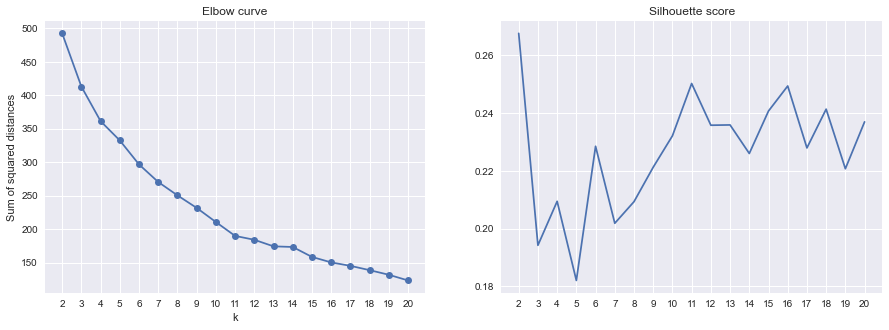

In [33]:
ffa.plot_ec_silhouette(X_knn, random_state)

In [34]:
kmeans_o = KMeans(n_clusters=6, init='k-means++',random_state = random_state).fit(X_knn)
labels = kmeans_o.labels_
knn_o['class knn'] = labels+1

In [35]:
ffa.clusters(knn_o, 'class knn')

,Etmath,Etph,Etch,AT1,AT2,Exam,N
class knn,,,,,,,
1,0.76,0.75,0.18,0.67,0.69,0.85,9
2,0.34,0.14,0.17,0.55,0.49,0.64,10
3,0.75,0.80,0.76,0.51,0.42,0.63,11
4,0.44,0.37,0.39,0.04,0.10,0.33,31
5,0.65,0.44,0.46,0.49,0.22,0.16,39
6,0.72,0.26,0.97,0.64,0.62,0.82,8


**Clusters of outliers detected by kNN:**
- **Cluster 1** - Good course performance with a good background in physics and mathematics. Students with good scores for enrolment tests in physics(0.75) and mathematics (0.76), who passed attestation tests with average scores and exam with good scores (0.85).
- **Cluster 2** - Average exam score despite failed tests. Students from this cluster have low scores for all enrolment tests and attestation tests. However, after they passed the exam with an average score (0.64).
- **Cluster 3** - Problems with attestation tests. Students with a high score for all enrolment tests, which passed the exam with an average score (0.63). However, they failed both attestation tests. 
- **Cluster 4** - Failed performance. Students who failed all tests.
- **Cluster 5** - Failed course performance. Students from this cluster have average scores for enrolment mathematics test (0.65), however, after they failed attestation and examination tests.
- **Cluster 6** - Good course performance with good background in chemistry and mathematics. Students with excellent scores for chemistry enrolment test (0.97) and good scores for mathematics enrolment tests (0.72) as well as for attestation and exam tests.

## CBLOF

In [36]:
cblof_o = df_outliers[df_outliers.cblof_10 == 1].copy()

In [37]:
X_cblof = np.array(cblof_o[features_name])
X_cblof = StandardScaler().fit_transform(X_cblof)

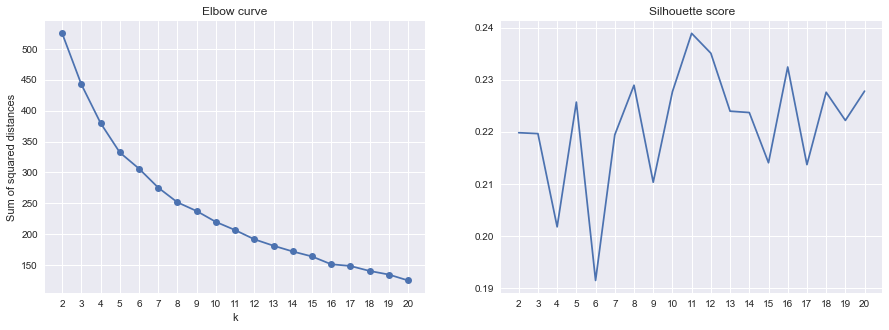

In [38]:
ffa.plot_ec_silhouette(X_cblof, random_state)

In [39]:
kmeans_o = KMeans(n_clusters=5, init='k-means++',random_state = random_state).fit(X_cblof)
labels = kmeans_o.labels_
cblof_o['class cblof'] = labels+1

In [40]:
ffa.clusters(cblof_o, 'class cblof')

,Etmath,Etph,Etch,AT1,AT2,Exam,N
class cblof,,,,,,,
1,0.67,0.69,0.56,0.43,0.28,0.62,25
2,0.67,0.44,0.40,0.47,0.28,0.08,42
3,0.46,0.37,0.45,0.03,0.05,0.36,20
4,0.36,0.14,0.16,0.55,0.50,0.63,11
5,0.79,0.43,0.59,0.81,0.73,0.91,10


**Clusters of outliers detected by CBLOF:**
- **Cluster 1** - Problems with attestation tests. Students with average scores for all enrolment tests and the exam. However, they failed both attestation tests.
- **Cluster 2** - Failed course performance. Students from this cluster have average scores for enrolment mathematics test (0.67), however, after they failed attestation and examination tests.
- **Cluster 3** - Failed performance. Students who failed all tests.
- **Cluster 4** - Average exam score despite failed tests. Students from this cluster have low scores for all enrolment tests and attestation tests. However, after they passed the exam with an average score (0.63).
- **Cluster 5** - Good course performance with good background in chemistry and mathematics. Students with average scores for chemistry and mathematics enrolment tests as well as for attestation and exam tests.

## HBOS

In [41]:
hbos_o = df_outliers[df_outliers.hbos_10 == 1].copy()

In [42]:
X_hbos = np.array(hbos_o[features_name])
X_hbos = StandardScaler().fit_transform(X_hbos)

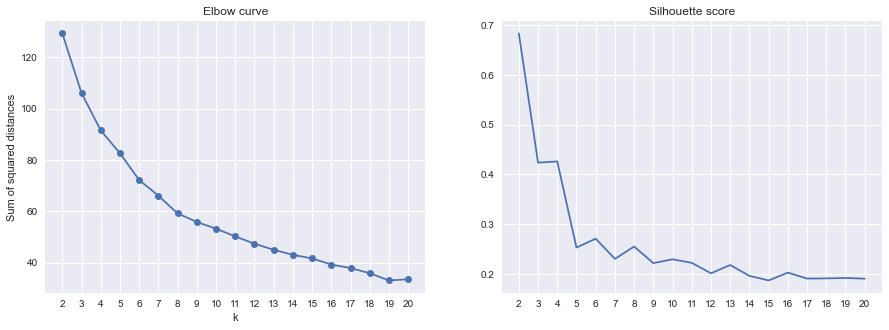

In [43]:
ffa.plot_ec_silhouette(X_hbos, random_state)

In [44]:
kmeans_o = KMeans(n_clusters=5, init='k-means++',random_state = random_state).fit(X_hbos)
labels = kmeans_o.labels_
hbos_o['class hbos'] = labels+1

In [45]:
ffa.clusters(hbos_o, 'class hbos')

,Etmath,Etph,Etch,AT1,AT2,Exam,N
class hbos,,,,,,,
1,0.31,0.21,0.19,0.25,0.17,0.40,16
2,0.89,0.80,0.73,0.75,0.74,0.85,41
3,0.13,0.14,0.22,0.17,0.14,0.15,28
4,0.81,0.76,0.25,0.77,0.72,0.90,9
5,0.81,0.48,0.88,0.80,0.77,0.95,14


**Clusters of outliers detected by HBOS:**
- **Cluster 1** - Good performance. Students with good scores for all tests.
- **Cluster 2** - Good course performance with a good background in chemistry and mathematics. Students with good scores for all tests, except ETph, who passed exams with excellent score (0.95).
- **Cluster 3** - Good course performance with good background in physics and mathematics. Students with good scores for all tests, except ETch, who passed exams with excellent score (0.9).
- **Clusters 4-5** - Failed performance. Students who failed all tests.

## LOF

In [46]:
lof_o = df_outliers[df_outliers.lof_10 == 1].copy()

In [47]:
X_lof = np.array(lof_o[features_name])
X_lof = StandardScaler().fit_transform(X_lof)

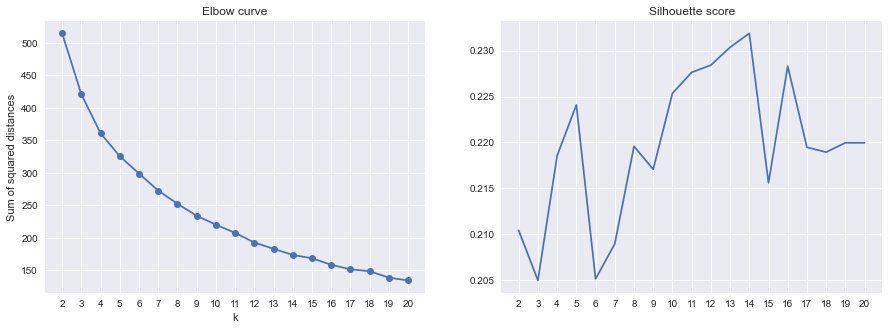

In [48]:
ffa.plot_ec_silhouette(X_lof, random_state)

In [49]:
kmeans_o = KMeans(n_clusters=5, init='k-means++',random_state = random_state).fit(X_lof)
labels = kmeans_o.labels_
lof_o['class lof'] = labels+1

In [50]:
ffa.clusters(lof_o, 'class lof')

,Etmath,Etph,Etch,AT1,AT2,Exam,N
class lof,,,,,,,
1,0.42,0.16,0.22,0.52,0.57,0.66,20
2,0.44,0.37,0.42,0.08,0.10,0.43,28
3,0.77,0.61,0.86,0.55,0.39,0.72,12
4,0.70,0.81,0.20,0.65,0.65,0.84,11
5,0.69,0.46,0.46,0.49,0.23,0.20,37


**Clusters of outliers detected by LOF:**
- **Cluster 1** - Average exam score despite failed tests. Students from this cluster have low scores for all enrolment tests and AT1, however, after they tried to reestablish and passed AT2 and exam with average scores.
- **Cluster 2** - Failed performance. Students with failed performance for all tests.
- **Cluster 3** - Problems with attestation tests. Students with average scores for all enrolment tests and the exam. However, they failed both attestation tests.
- **Cluster 4** - Good course performance with good background in physics and mathematics. Students with good scores for mathematics and physics enrolment tests as well as for attestation and exam tests.
- **Cluster 5** - Failed course performance. Students from this cluster have average scores for enrolment mathematics test (0.69), however, after they failed attestation and examination tests